# Evidence Transfer

In [1]:
from models.unet import create_unet
from models.evitram import create_evidence_transfer_model
import tensorflow as tf

unet = create_unet()
unet.load_weights('model-best.h5')

q_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid'),
], name='Q')

evitram = create_evidence_transfer_model(unet, q_model, 'expanding_block_64_conv2')

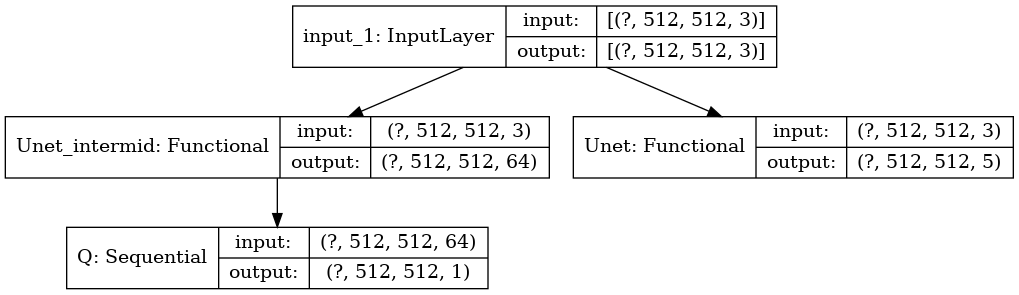

In [2]:
import tensorflow as tf

tf.keras.utils.plot_model(evitram, show_layer_names=True, show_shapes=True)

In [3]:
from metrics import CategoricalMeanIou

evitram.compile(optimizer='adam', metrics=[
    [CategoricalMeanIou(num_classes=5), 'accuracy'],
    ['accuracy']
])

In [4]:
!mkdir -p /tmp/ds_cache/
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')

def split_outputs(x, y, z):
    return x, (y, z)

FOLDS = 2
train_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='training', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)
val_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='validation', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)

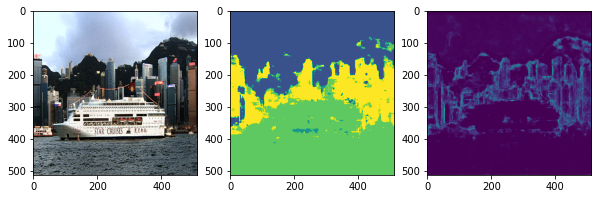

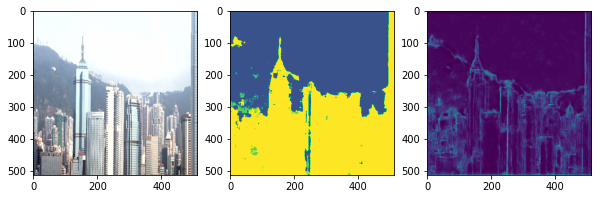

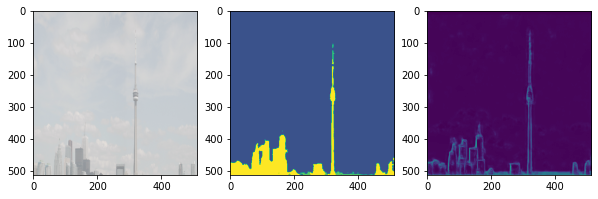

In [5]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)

In [7]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.data.experimental import AUTOTUNE
from utils import get_new_logdir

log_dir = get_new_logdir(root_dir='./logs')
batch_size = 3
evitram.fit(
    train_ds.batch(batch_size).prefetch(AUTOTUNE),
    epochs=5,
    validation_data=val_ds.batch(batch_size).prefetch(AUTOTUNE) ,
    callbacks=[
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
        )
    ]
)

Epoch 1/5
      1/Unknown - 0s 17ms/step - loss: 1.1697 - Unet_categorical_mean_iou: 0.4564 - Unet_accuracy: 0.8523 - Q_accuracy: 0.8746WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
80/80 [==============================] - 59s 735ms/step - loss: 0.5858 - Unet_categorical_mean_iou: 0.5408 - Unet_accuracy: 0.8970 - Q_accuracy: 0.9452 - val_loss: 0.7551 - val_Unet_categorical_mean_iou: 0.5052 - val_Unet_accuracy: 0.9132 - val_Q_accuracy: 0.9535
Epoch 2/5
80/80 [==============================] - 58s 728ms/step - loss: 0.4991 - Unet_categorical_mean_iou: 0.5781 - Unet_accuracy: 0.9113 - Q_accuracy: 0.9511 - val_loss: 0.8005 - val_Unet_categorical_mean_iou: 0.5144 - val_Unet_accuracy: 0.9139 - val_Q_accuracy: 0.9535
Epoch 3/5
80/80 [==============================]

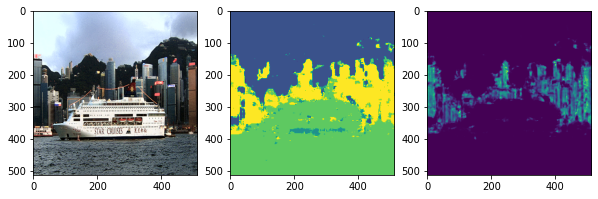

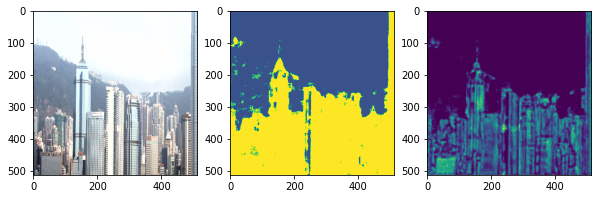

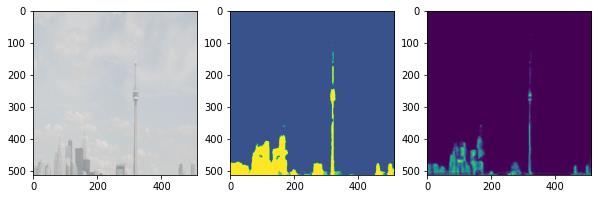

In [8]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)